<img src="https://raw.githubusercontent.com/UCLAMAEThreads/FluidDynTools.jl/main/notebook/logo_UCLA_blue_boxed.svg" alt="ucla logo" width="150" align="left"/>

### **Introduction to Fluid Dynamics**
<hr />

# Boundary layer of a flow past a flat plate
In this notebook, we will inspect a solution of the Navier-Stokes equations for
the flow past a stationary flat plate. We assume that the flow is steady,
two-dimensional, and incompressible, but we don't make any other assumptions about
the flow.

The purpose of this notebook is to see the boundary layer and the force on the
plate in the full Navier-Stokes environment, and to see some of the basic features
of the laminar boundary layer.

The main scope of this notebook is a flat plate arranged tangent to the free stream
 (i.e., we say the plate is at 0 angle of attack). This allows us to look at the
 boundary layer in its most basic form.

The flow is precomputed, so we will simply load it in.

### Set up the module

In [1]:
using FluidDynTools

In [2]:
using ViscousFlow
import ViscousFlow: force
using Plots

#### Set the flow parameters and compute the Reynolds number
Let's denote the length of the plate by $L$ and the freestream velocity by $U_\infty$,
The Reynolds number is defined from this characteristic length and velocity:

$$ Re = \rho U_\infty L/\mu = U_\infty L/\nu $$

To ensure that we have a laminar boundary layer, we will study a boundary
layer at Reynolds number 500. This is quite low, but is faster to simulate
numerically. The numbers we provide for density, viscosity, flow speed, and plate
length are just designed to get this Reynolds number. None of them matter
individually. **We would get the same boundary layer behavior if they
were all different but produced the same Reynolds number.**

In [3]:
ρ = 1
ν = 0.002
U∞ = 1
L = 1
Re = U∞*L/ν

500.0

Now let's load in the solution

In [4]:
u, t, sys = load_ns_solution("FlatPlateRe500.jld2");

For later use, let's get the vorticity, velocity, and streamfunction:

In [5]:
ω = ViscousFlow.vorticity(u,sys,t)
vel = ViscousFlow.velocity(u,sys,t)
ψ = ViscousFlow.streamfunction(u,sys,t);

### The vorticity
The vorticity field below shows the characteristics of a boundary layer: it is
**produced** at the plate surface, **diffused** away from it, and **convected** downstream.
Since convection is stronger than diffusion the further we are from the wall,
this vorticity remains inside of a relatively thin layer (the boundary layer).
Ultimately, the boundary layers on each side merge behind the plate to form
the wake.

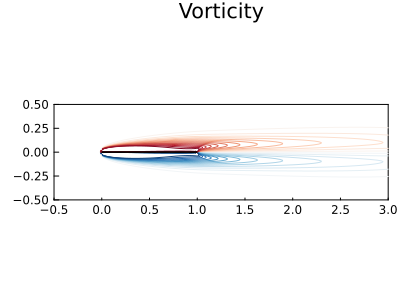

In [6]:
plot(ω,sys,title="Vorticity",clim=(-10,10),levels=range(-10,10,length=30), color = :RdBu,xlim=(-0.5,3),ylim=(-0.5,0.5))

### Streamlines
Let's view the streamlines by plotting streamfunction contours. It is helpful
to consider first what this plot would look like if there were no viscosity.
Then, it would be a potential flow everywhere, and that potential flow
would simply be uniform flow! In other words, this infinitely thin flat
plate at zero angle would produce no effect on the flow. The streamlines would
be straight.

Here, in viscous flow, the streamlines are slightly bowed outward as they
pass the plate. This means that the flow is slowing down as it passes the plate
(due to viscosity). It also means that, to the potential flow outside the boundary layer,
the plate appears thicker than zero and a little bit rounded (parabola shaped).

Behind the plate, the streamlines bow back inward a bit.

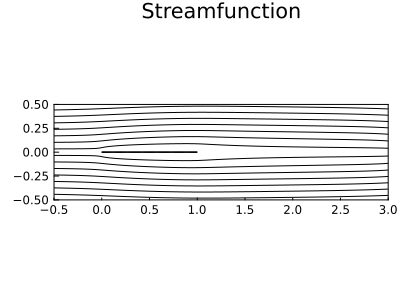

In [7]:
plot(ψ,sys,title="Streamfunction",color=:black,xlim=(-0.5,3),ylim=(-0.5,0.5))

### Velocity
Let's plot the velocity profile at different places along the plate. To do that,
we first get a version of the $u$ and $v$ components that we can evaluate
anywhere.

In [8]:
ufcn, vfcn = interpolatable_field(vel,sys.base_cache.g);

For example, we can evaluate the $x$ component of velocity at $(0.5,0.25)$:

In [9]:
ufcn(0.5,0.25)

1.0331024310624868

Let's plot the $u$ profile at three $x$ locations along the wing. In each case,
we display the velocity as a function of $y$, above the plate:

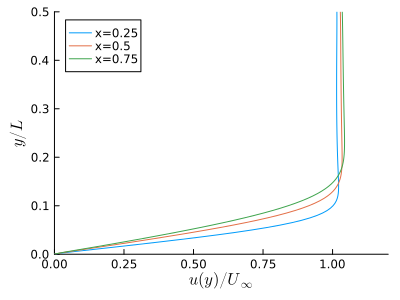

In [10]:
ysamp = range(0,0.5,length=101)
xsamp = [0.25, 0.5, 0.75]
p = plot(xlim=(0,1.2),ylim=(0,0.5),xlabel=L"u(y)/U_\infty",ylabel=L"y/L",legend=true)
for x in xsamp
    Ue = ufcn(x,0.5) # estimate of the external velocity
    plot!(p,ufcn.(x,ysamp .+ cellsize(sys)/2),ysamp,label=string("x=",x))
end
p

Some observations:
1. The shape of the profile looks about the same at every point, but the
layer is clearly getting thicker as $x$ increases.

In fact, we can predict, based on dimensional analysis, that the boundary
layer thickness should grow like this:

$$\delta(x) \propto \sqrt{\nu x/U_e(x)}$$

This is very similar to the Rayleigh problem, except that time is replaced
by the time-like quantity $x/U_e(x)$ -- approximately the time required to travel
from the leading edge to distance $x$ downstream. By convention, we stick
a factor of 2 in this:

In [11]:
δ(x,Ue,ν) = √(2*ν*x/Ue)

δ (generic function with 1 method)

Another observation:
2. There appears to be some small differences in the velocity outside
the boundary layer. The velocity outside the boundary layer, $U_e$, is a little bit faster
than the free stream.

Let's plot the vertical velocity:

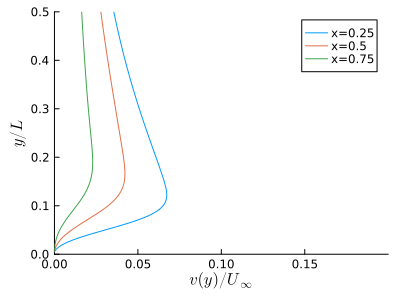

In [12]:
ysamp = range(0,0.5,length=101)
xsamp = [0.25, 0.5, 0.75]
p = plot(xlim=(0.0,0.2),ylim=(0,0.5),xlabel=L"v(y)/U_\infty",ylabel=L"y/L",legend=true)
for x in xsamp
    plot!(p,vfcn.(x,ysamp .+ cellsize(sys)/2),ysamp,label=string("x=",x))
end
p

Here, we see that the vertical velocity is a lot smaller than the horizontal
velocity. This should not be a surprise. From continuity,

$$ \dfrac{\partial u}{\partial x} + \dfrac{\partial v}{\partial y} = 0 $$

We expect the first of these derivatives to scale like $U_e/x$. We expect
the second to scale like $V/\delta$, where $V$ is the characteristic
speed of the vertical flow. Since continuity requires that these terms
are the same order of magnitude (since they must sum to zero), then

$$ V = U_e \dfrac{\delta}{x} $$

The boundary layer thickness is very small compared with $x$, so **$V$ must
be very small compared to $U_e$**.

### Drag coefficient
Let's compute the force on the plate. (Remember, this is force per unit width,
since this is 2-d.)

In [13]:
fx, fy = force(u,sys,t,1)

(0.07339459182909512, -7.762445580692785e-15)

The drag coefficient is $C_D = f_x/\frac{1}{2}\rho U_\infty^2 L$

In [14]:
CD = fx/(0.5*ρ*U∞^2*L)

0.14678918365819024

The lift coefficient is $C_L = f_y/\frac{1}{2}\rho U_\infty^2 L$

In [15]:
CL = fy/(0.5*ρ*U∞^2*L)

-1.552489116138557e-14

It should not be surprising that the lift is zero, since the flow is symmetric.

We will come back to these points soon. In the next notebook, we will
discuss the Blasius boundary layer solution.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*